# Portfolio Optimization Project

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

First we need to choose a set of stocks to inclue in the portfolio. For this example, I will just use a collection of big tech stocks.

In [4]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

endDate = datetime.today()
startDate = endDate - timedelta(days=5*365)
data = yf.download(tickers, start='startDate')['Adj Close'] # Just looking at closing price

[*********************100%***********************]  5 of 5 completed

5 Failed downloads:
['VTI', 'SPY', 'GLD', 'BND', 'QQQ']: ValueError("time data 'startDate' does not match format '%Y-%m-%d'")


Now that we have this data we can calculate the daily returns for each stock in our "portfolio". Additionally, we can calculate the mean returns (expected returns) and the covariance matrix.

In [30]:
returns = data.pct_change().dropna()

mean_returns = returns.mean()

cov_matrix = returns.cov()

Now that we have some inputs, we can define some functions to calculate portfolio performance metrics such as return, volatility (std dev) and the Sharpe ratio.

In [31]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std_dev

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std_dev

We can now use an optimization technique to maximize the Sharpe Ratio (return per unit of risk). This involves finding the weights for each stock that results in the highest Sharpe Ratio.

In [32]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})

bounds = tuple((0,1) for _ in range(len(tickers)))

initial_weights = np.array([1. / len(tickers)] * len(tickers))

optimal_results = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                           method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal_results.x

Now we can calculate the performance of the optimal portfolio and display the results

In [34]:
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
optimal_sharpe = (optimal_return - 0.01) / optimal_volatility

print(f"Optimal Weights: {optimal_weights}")
print(f"Expected Annual Return: {optimal_return}")
print(f"Annual Volatility: {optimal_volatility}")
print(f"Sharpe Ratio: {optimal_sharpe}")

Optimal Weights: [3.26502344e-01 1.23428134e-01 2.48282297e-17 4.77048956e-18
 3.05745013e-17 1.05920189e-01 4.44149333e-01]
Expected Annual Return: 0.4698851950681074
Annual Volatility: 0.3775522786427513
Sharpe Ratio: 1.218070241083782


Now we can visualize the efficient frontier by looking at the risk-return trade-off, generating a series of random portfolios and plotting them along with the optimal portfolio.

In [35]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = p_return
        results[1,i] = p_volatility
        results[2,i] = (p_return -  risk_free_rate) / p_volatility

    return results, weights_record


In [36]:
num_portfolios = 1000
results, weights_record = random_portfolios(num_portfolios, mean_returns, cov_matrix)

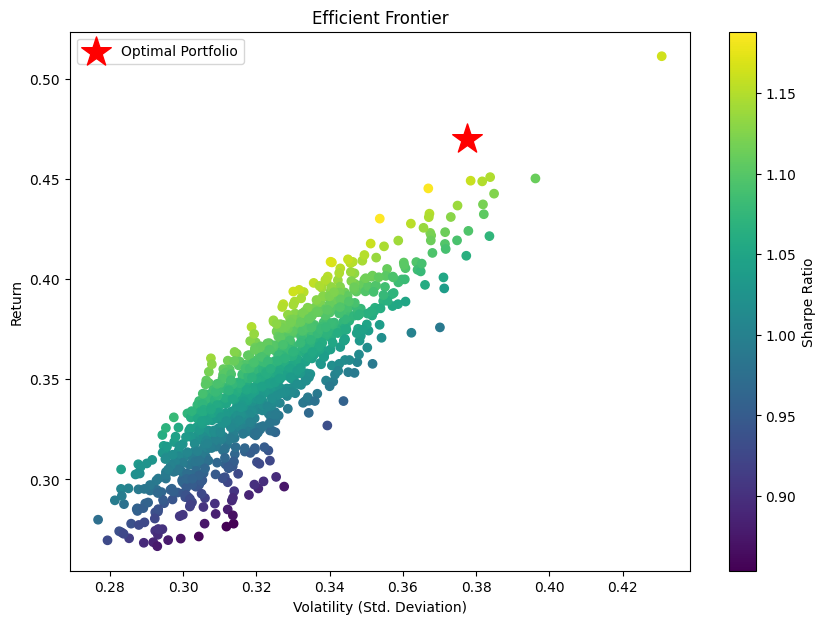

In [50]:
plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=500, label='Optimal Portfolio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()

We also can add a benchmark of comparison

In [56]:
benchmark_data = yf.download('^GSPC', start='2018-01-01')['Adj Close']

benchmark_returns = benchmark_data.pct_change().dropna()

portfolio_daily_returns = returns.dot(optimal_weights)
portfolio_cumulative_return = (1 + portfolio_daily_returns).cumprod()-1
benchmark_cumulative_return = (1 + benchmark_returns).cumprod()-1

[*********************100%***********************]  1 of 1 completed


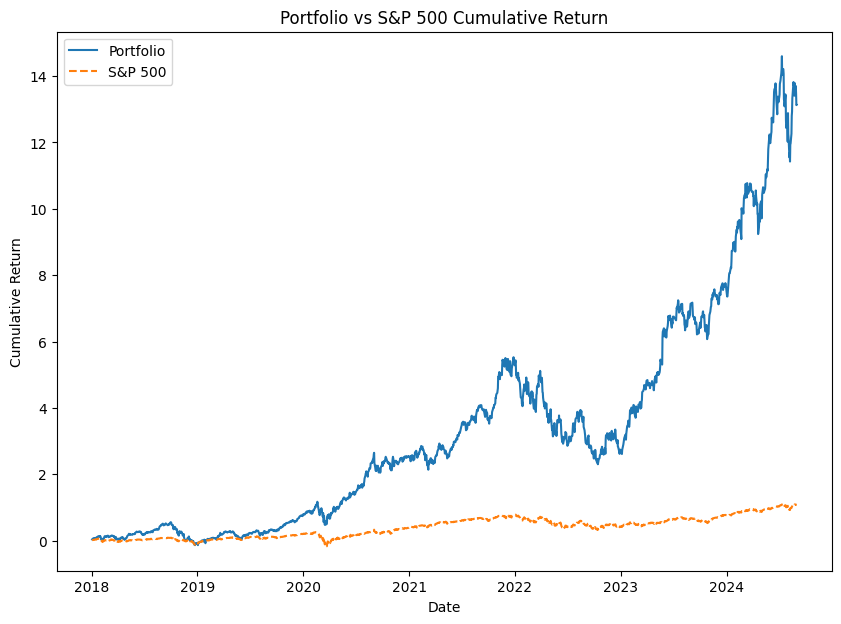

In [57]:
plt.figure(figsize=(10, 7))
plt.plot(portfolio_cumulative_return, label='Portfolio')
plt.plot(benchmark_cumulative_return, label='S&P 500', linestyle='--')
plt.title('Portfolio vs S&P 500 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()